## 1. Loading libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pickle
import seaborn as sns
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


## 2. Loading data which needs to be trained

In [30]:
path = os.path.join('../data', 'treatments_2017-2020_train')
df = pd.read_parquet( path + '.parquet')
print(df.shape)


(3638892, 22)


Selecting only a batch of data since the dataset is quite huge

In [31]:
batch = 10000
df = df.sample(batch,random_state=42).reset_index(drop=True)

X = df.drop("NOPRIOR", axis=1)
y = pd.DataFrame(df["NOPRIOR"])


## 3. Splitting the dataset into train(70%) and test(30%)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

X_train.to_parquet( os.path.join('../data', 'X_train' + '.parquet')    )
y_train.to_parquet( os.path.join('../data', 'y_train' + '.parquet')  )

X_test.to_parquet( os.path.join('../data', 'X_test' + '.parquet')    )
y_test.to_parquet( os.path.join('../data', 'y_test' + '.parquet')  )

## 4. Performing One hot encoding to the train set 

In [33]:
# features which needs to be one hot encoded
columns_one_hot = ['GENDER', 'RACE', 'ETHNIC', 'MARSTAT', 'EMPLOY', 'VET' ,	'LIVARAG',	'PRIMINC',
                   'DIVISION',	'SERVICES' ,  'PSOURCE' , 	'SUB1' , 	'FREQ1', 
                   'PSYPROB' ,	'FREQ_ATND_SELF_HELP']

In [34]:
# def ohe class
ohe = OneHotEncoder(sparse=False) 

# reset index on X_train since we will need it to concatenate 
X_train = X_train.reset_index(drop=True)
# fit the X_train data 
ohe.fit( X_train[columns_one_hot] )

# save the encoder(in the artifacts folder) since it will be required further for unseen test data
path_to_encoder = os.path.join(  '../artifacts', 'encoder' + '.pkl')
pickle.dump(ohe, open(path_to_encoder, 'wb'))


In [35]:
# transform X_train with the encoded features. Here we drop the original categorical features 
ohe_X_train_df = pd.DataFrame(ohe.transform(X_train[columns_one_hot]), columns=ohe.get_feature_names_out())
X_train = X_train.drop(columns=columns_one_hot, axis=1)
X_train = pd.concat([X_train,ohe_X_train_df], axis=1 )
y_train = y_train.reset_index(drop=True)


print( 'X_train shape : {}, y_train shape : {} '.format(  X_train.shape, y_train.shape  ))

X_train shape : (2547224, 73), y_train shape : (2547224, 1) 


## 5. Train XGBoost model with basic tuning. 

We didn't try many models due to lack of time and assuming that boosting models generaly works better for tabular datasets.

In [36]:


start = time.time()


model = XGBClassifier()

# hyperparameters
parameters = {
                    'learning_rate':[.1,.01,.05,.001],
                    'n_estimators': [8,16,32,64,128,256]
                }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.accuracy_score)

#  Randomized search
randomized_search_obj = RandomizedSearchCV(model, parameters,cv=3)
randomized_search_obj = randomized_search_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
best_model = randomized_search_obj.best_estimator_

# Fit the best algorithm to the data.
best_model.fit(X_train, y_train)

# save model
path_to_model = os.path.join(  '../artifacts', 'best_model' + '.pkl')
pickle.dump(best_model, open(path_to_model, 'wb'))


end = time.time()


print('Time taken by model training : {}'.format(end-start))

Time taken by model training : 9268.389284849167


## 6. Evaluation

In [41]:
def metrics_report(model,features,target):


    predictions = model.predict(features)
#    features = pd.get_dummies(features, columns=columns_one_hot, drop_first=True)
    acc = accuracy_score(target, predictions)  # to compute Accuracy
    recall = recall_score(target, predictions)  # to compute Recall
    precision = precision_score(target, predictions)  # to compute Precision
    f1 = f1_score(target, predictions)  # to compute F1-score

        # creating a dataframe of metrics
    df_metrics = pd.DataFrame({
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1 Score": f1,
            },index=[0],)

    return df_metrics


In [81]:
metrics_train = metrics_report(best_model,X_train,y_train)
print('Training set metrics ::')
metrics_train


Training set metrics ::


,Accuracy,Recall,Precision,F1 Score
0,0.743991,0.854379,0.772287,0.811262


In [79]:
# transform X_test with the encoded features. Here we drop the original categorical features 

#loading test data 
X_test = pd.read_parquet('../data/X_test.parquet')
y_test = pd.read_parquet('../data/y_test.parquet')

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


ohe_X_test_df = pd.DataFrame(ohe.transform(X_test[columns_one_hot]), columns=ohe.get_feature_names_out())
X_test = X_test.drop(columns=columns_one_hot, axis=1)
X_test = pd.concat([X_test,ohe_X_test_df], axis=1 )

In [82]:
metrics_test = metrics_report(best_model,X_test,y_test)
print('Test set metrics :: ')
metrics_test

Test set metrics :: 


,Accuracy,Recall,Precision,F1 Score
0,0.742259,0.852991,0.771093,0.809977


# Confusion matrix 

Text(50.722222222222214, 0.5, 'Actual')

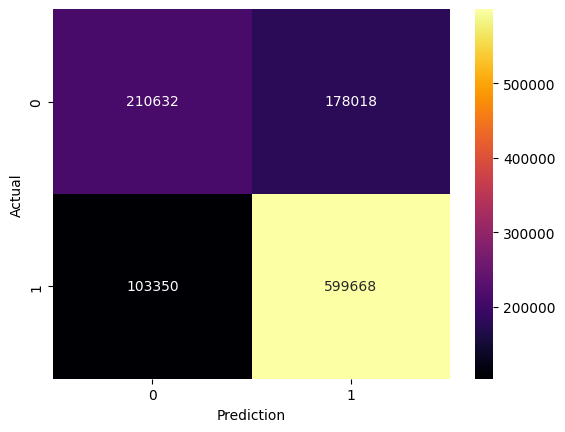

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, best_model.predict(X_test), labels=best_model.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)

#disp.plot()

#plt.show()
sns.heatmap(cm,annot=True,fmt=".0f", cmap='inferno')
plt.xlabel('Prediction')
plt.ylabel('Actual')